In [1]:
import numpy as np
import pandas as pd
import os
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='whitegrid')

import itertools as it

from os.path import join as pjoin

%config InteractiveShell.ast_node_interactivity='all'
%config InlineBackend.figure_format = 'svg'

# Community Model DataFrame

In [2]:
path = '../data_o/calibration/community_calibration/parsed_data/'
fname = 'community_calibration_dataframe.csv'

mdf = pd.read_csv(pjoin(path,fname), sep=',', index_col='well')

In [3]:
######################################
# correct values used for regression #
######################################
for col in [i for i in mdf.columns[4:].values if 'sdv' not in i]:
    #subtract 'blank' well values
    mdf.loc[:,col] = mdf.loc[:,col] - mdf.loc['H12',col]

In [4]:
mdf[['A750', '750', '730', 'A680','680']].tail()

,A750,750,730,A680,680
well,,,,,
H8,0.2731,0.2467,0.2588,0.5329,0.5277
H9,0.2280,0.1872,0.1967,0.4347,0.3984
H10,0.1787,0.1467,0.1542,0.3366,0.3155
H11,0.1162,0.0972,0.1024,0.2207,0.2096
H12,0.0000,0.0000,0.0000,0.0000,0.0000


# Helper Functions

In [5]:
def absfluo_extractor(typ, abs_lmda, dframe):
    """This function returns a df which can be merged
    with temp df append the measurements"""
    typ = typ
    
    abs_lmda = abs_lmda
    
    tdf =  df.loc[(df['type']==typ) & (df['wavelen']==abs_lmda)][['well','measurement']].set_index(keys='well')     
    
    return tdf.rename({'measurement':typ[0]+abs_lmda[0:3]}, axis=1)


def get_row_col_values(df, plate_row_or_col='row', df_col_name='A680'):
    """This function returns the values of either a row or column of the 96 well
    as given in the dataframe. These values are later used to perform a linear 
    regression using scipy.optimize function ROW refers to the chlamy related 
    values, and COL to the bacteria related ones"""
    
    rows = df['row'].unique()
    cols = df['col'].unique()
    
    values_list = []
    if plate_row_or_col=='row':
        for row in rows:
            values_list.append(df.loc[df['row']==row, df_col_name].to_list())
    
    else:
        for col in cols:
            values_list.append(df.loc[df['col']==col, df_col_name].to_list())
                               
    
    return values_list


# linear curve
def linear_curve(parameters, xdata):
    """
    A680 & A750 show a linear relationship:
    y = m*x + b
    
    m = slope
    b = y-intercept
    """
    m = parameters[0]
    b = parameters[1]
    
    return m*xdata + b


def linear_curve_residuals(parameters, xdata, ydata, function):
    """
    xdata = [C] || [B]  (Regresso)
    
    ydata = A680 || A750
    
    Computes the residuals of y_pred -y_obs, where:
        y_pred = line(parameters, xdata)
    """
    
    return linear_curve(parameters,xdata) - ydata


def root_curve(parameters, xdata):
    """
    F680 shows an obvious root-function relationship:
    
    y = a√(b*x)
    
    'a' and 'b' control area under the curve with
    'b' doing so much more slowly
    
    NOTE: 
        
        the following permutations of this model were
        also made :
            y = √(b*x)
            y = a√(x)
        
        however these mono-parameter models produce large
        coefficients thus the best model to use is below:
            y = a√(b*x)
    
    """
    
    a = parameters[0]
    b = parameters[1]
    
    return a*np.sqrt(b*xdata)


def root_curve_residuals(parameters, xdata, ydata, function):
    """
    xdata = [chlamy] or [bacter]
    
    ydata = observed F680
    
    Computes the residuals of y_pred - y_obs, where
    y_pred = root_curve(parameters, xdata)
    
    """
    
    return root_curve(parameters, xdata) - ydata


def scipy_optfit_caller(regressor, regressand, x0=[0,0], abfl='abs'):
    """This function returns the fitted parameter for every pair of regressor
    i.e. Concentration/Labels/Absorbance @! 680||720 wavelengths using the
    scipy.optimize least squares function and regressand
    i.e. the measured signal at the A680 and A750 wavlengths
    """
    parameters = []
    if abfl=='fluo':
        funk = root_curve_residuals
        funk2= root_curve
    else:
        funk = linear_curve_residuals
        funk2= linear_curve
        
    for ys in regressand:
        optmize_result = scipy.optimize.least_squares(funk, x0,
                                                     args = (regressor, ys, funk2))
        parameters.append(optmize_result.x)
    
    return parameters

def set_B_and_C(tdf, column):
    """This helper function sets the concentraiton values B and
    C on the dataframe for regressiong purposes and so that the 
    plotting function can plot the right values on the x-axis"""
    
    df = tdf.copy()
    
    rows = df['row'].unique()
    cols =  df['col'].unique()
    
    for row in rows:
        value = df.loc[(df['row']==row) & (df['col']==12), column][0]
        df.loc[df['row']==row, 'B'] = value

    for col in cols:
        value = df.loc[(df['row']=='H') & (df['col']==col), column][0]
        df.loc[df['col']==col, 'C'] = value
    
    return df

In [6]:
def plot_col_rows(df, kParams, first_regressand='A680', second_regressand='A750', regressor='560', plate_row_or_col='row'):
    """This function plots the linear regression made on each of the rows
    and columns of the 96well plate data. This is done in order to observe
    how the addition of bacteria to chlamy and vice versa affects the 
    absorbance. However only Col12 and RowH are needed to create the regression
    curves/calibration curves that are needed for the analysis and development
    of the model that will be fitted to the PBR data
    
    kParams should be a touple of respective 680/720 parameters
    kParamsX[0] are the 680 parameters and,
    kParmasX[1] are the 750 paramters
    """
    
    # one A4 sized figure is created with, but needs to be variable
    # on the amount of rows and columns because there are 8 rows
    # and 12 columsn on a 96 well plate
    
    fr = first_regressand
    sr = second_regressand
    rg = regressor
    
    mx = max(df[sr].max(), df['A680'].max())
    cx = df['C'].max()
    bx = df['B'].max()
    
    if plate_row_or_col=='row':
        R=4
        fs = (8,11)
        xmax= cx+0.05
        
        # mock data the line using the kX parameter 
        xmock = np.linspace(-0.02, cx+0.02, 100)
    
    if plate_row_or_col=='col':
        R=6
        fs = (8,16)
        xmax= bx+0.05
        # mock data the line using the kX parameter 
        xmock = np.linspace(-0.02, bx+0.02, 100)
    
        
  
    plt.figure(figsize=fs)
    gs = gridspec.GridSpec(R,2)
    axes = []
    for r in range(0,R):
        for c in [0,1]:
            axes.append(plt.subplot(gs[r,c]))

            
    # concentrations from 'labels'
    chlamy_cnt_lst = df['C'].unique()
    bacter_cnt_lst = df['B'].unique()


    # access axes through generator
    axes = (ax for ax in axes)
     
    ymin=-0.1
    ymax= mx+0.05*mx
    xmin=-0.04
    
    if plate_row_or_col=='row':
        
        rows=df['row'].unique()
        
        i = 0
        rows=df['row'].unique()
        for row in rows:

            ax=next(axes)
            
            df.loc[df['row']==row].plot(x='C', y=[fr, sr],
                                        style='x', ax=ax)
            ax.set_ylim(ymin,ymax)
            ax.set_xlim(xmin,xmax)
            ax.set_xlabel('['+rg+']')
            ax.set_ylabel(fr+' || '+sr)
            
            ax.legend(loc=2, title='@'+'[b]='+str(bacter_cnt_lst[i].round(4)), prop={'size': 8})
            ax.plot(xmock, linear_curve(kParams[0][i], xmock))
            ax.plot(xmock, linear_curve(kParams[1][i], xmock))

            i+=1
        plt.tight_layout()
        plt.suptitle('Absorbances @ Constant [B]', y=1.02)
    
        
        
    if plate_row_or_col=='col':

        cols=df['col'].unique()
        i=0
        for col in cols:

            ax=next(axes)
            df.loc[df['col']==col].plot(x='B', y=[fr, sr],
                                        style='x', ax=ax)
            
            ax.set_ylim(ymin,ymax)
            ax.set_xlim(xmin,xmax)
            ax.set_xlabel('['+rg+']')
            ax.set_ylabel(fr+' || '+sr)
            
            ax.legend(loc=2, title='@'+'[c]='+str(chlamy_cnt_lst[i].round(4)), prop={'size': 7})
            ax.plot(xmock, linear_curve(kParams[0][i], xmock))
            ax.plot(xmock, linear_curve(kParams[1][i], xmock))
            
            i+=1

        plt.tight_layout()
        plt.suptitle('Absorbances @ Consant [C]', y=1.02)


# Data Viz Setup 680 & 750

# change regressor-ands to see the separation of the coefficients

In [7]:
# Currently I'm just regressor as 560, but if changed then everything in this
# this box should be run so that the values match accordingly

#special model 750 ~ 680 + 540

regr = '750'
mdf = set_B_and_C(mdf, column=regr)

fst_regd = '680' # ALWAYS A680, anything else is for testing
sec_regd = '720' #'720' or 'A750' or 'A730' anything else is for testing
# this is because the PBR system and data previously collected were
# obtained using these lamda.... 
#################################################

# store absorbance values that will be plotted on one figure  [chlamy]
A680_C = get_row_col_values(mdf, 'row', df_col_name=fst_regd)
A720_C = get_row_col_values(mdf, 'row', df_col_name=sec_regd)

# store absorbance values that will be plotted on one figure  [bacteria]
A680_B = get_row_col_values(mdf, 'col', df_col_name=fst_regd)
A720_B = get_row_col_values(mdf, 'col', df_col_name=sec_regd)

chlamy_cnt = mdf['C'].unique()
bacter_cnt = mdf['B'].unique()

kB_A680 = scipy_optfit_caller(bacter_cnt, A680_B)
kC_A680 = scipy_optfit_caller(chlamy_cnt, A680_C)
kB_A720 = scipy_optfit_caller(bacter_cnt, A720_B)
kC_A720 = scipy_optfit_caller(chlamy_cnt, A720_C)

print('kB_A680: ',kB_A680[-1][0],
'kC_A680: ',kC_A680[-1][0],
'kB_A720: ',kB_A720[-1][0],
'kC_A720: ',kC_A720[-1][0], sep='\n')

kB_A680: 
1.1386916729635272
kC_A680: 
2.142296556564764
kB_A720: 
1.0574253824922257
kC_A720: 
1.0828620378202007


In [8]:
def find_optimum_pair(df, fst, secd, regr):
   
    mdf =df.copy()
    mdf = set_B_and_C(mdf, column=regr)
    
    # store absorbance values that will be plotted on one figure  [chlamy]
    A680_C = get_row_col_values(mdf, 'row', df_col_name=fst)
    A720_C = get_row_col_values(mdf, 'row', df_col_name=secd)

    # store absorbance values that will be plotted on one figure  [bacteria]
    A680_B = get_row_col_values(mdf, 'col', df_col_name=fst)
    A720_B = get_row_col_values(mdf, 'col', df_col_name=secd)

    chlamy_cnt = mdf['C'].unique()
    bacter_cnt = mdf['B'].unique()

    kB68 = scipy_optfit_caller(bacter_cnt, A680_B)[-1][0]
    kC68 = scipy_optfit_caller(chlamy_cnt, A680_C)[-1][0]
    kB72 = scipy_optfit_caller(bacter_cnt, A720_B)[-1][0]
    kC72 = scipy_optfit_caller(chlamy_cnt, A720_C)[-1][0]
    
    
    Bp = kB72*kC68 - kB68*kC72
    #Cp =  kB68*kC72 - kB72*kC68
    
    return Bp

In [9]:
find_optimum_pair(mdf, fst_regd, sec_regd, regr)

1.0322727703030952

# Brute Force Optimal Regressands & Regressor
    
    Here we brute froce the finding of the optimal regressand and regressor,
    it was observed that the certain models provided compoletely irrational
    predictions. This observation led me to belive that the difference of
    the products of the coefficients in the models (the denominators in 
    each of the prediction B-hat C-hat models) could point me to a better value.
    This meant that there was a space of values which were better than other.
    
    The optimal model would thus have the largest magnitude in difference.
    
    My prediction turned out to be true and is most impressively---at least for
    this calibration dataset---the wavelengths which produce this 'Special' model
    are the same ones we're already using, except that they should be formed
    as follows:
    
    A680 = kB680[B]_750 + kC680[C]_750
    A560 = kB560[B]_750 + kC560[C]_750
    
    
    It may very well be the case that a higher absorbance as the regressor
    might produce better models, but our data only goes up to 750

In [10]:
# import time
# wavs = ['500', '510', '520', '530', '540', '550', '560',
#         '570', '580', '590', '600', '610', '620', '630', 
#         '640', '650', '660', '670', '680', '690', '700', 
#         '710', '720', '730', '740', '750']

# perm = it.permutations(wavs, 3)

# #t0
# start = time.time()
# dicky = {}
# for item in perm:
#     f, s, r = item
#     dicky[f, s, r] = find_optimum_pair(mdf, fst=f, secd=s, regr=r)

# #t1    
# end = time.time()

#print(end-start) 

In [11]:
# # 30 min run
# len(wavs)

# dif = pd.DataFrame.from_dict(dicky, orient='index')

# # these create the biggest difference which is relevant insofar as being furthest away from
# # zero as close to zero values either represent the same regressands, or that the
# # multiplication of the coefficients
# dif.loc[dif.idxmax()]
# dif.loc[dif.idxmin()]

# dif2 = dif[dif[0]!=0]

# dif2[1] = np.sqrt(np.power(dif2[0], 2))

# dif2.loc[dif2.idxmin()]
# dif2.loc[dif2.idxmax()]

# dif.to_csv('dicky.csv')

# Plot Viz

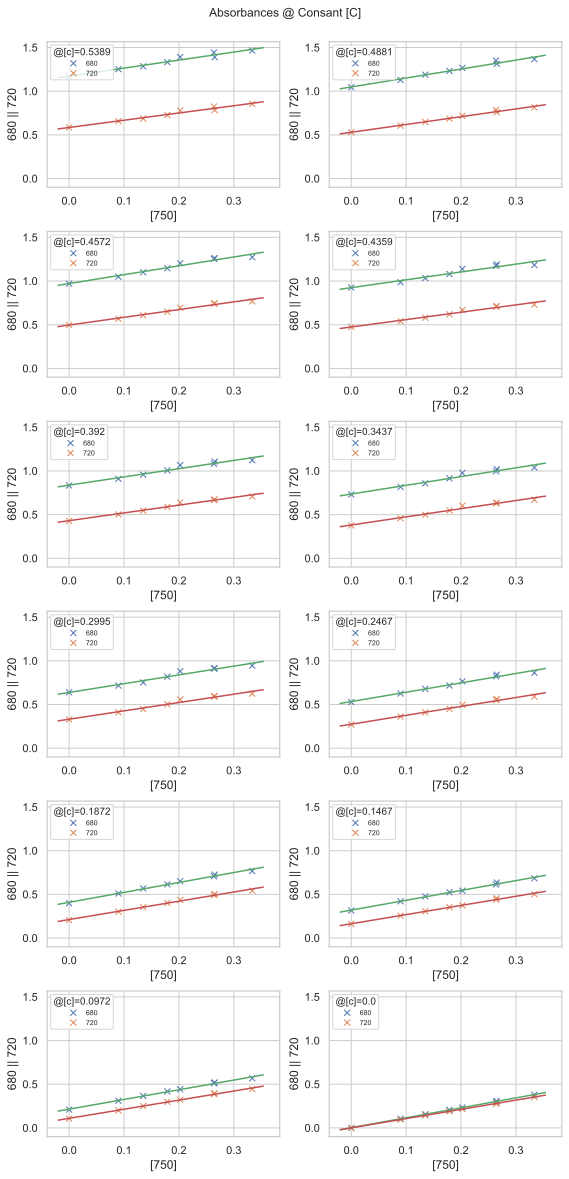

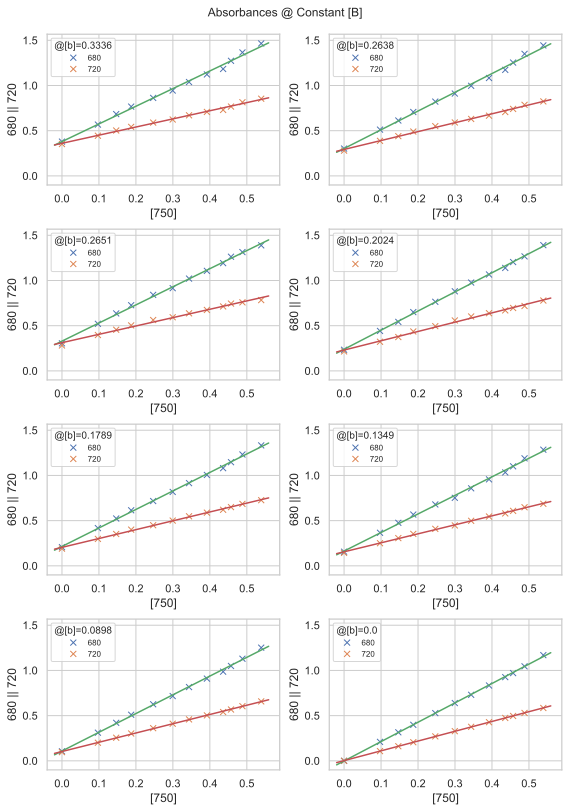

In [12]:
plot_col_rows(mdf, kParams=(kB_A680, kB_A720), first_regressand=fst_regd, 
              second_regressand=sec_regd, regressor=regr, plate_row_or_col='col')

plot_col_rows(mdf, kParams=(kC_A680, kC_A720), first_regressand=fst_regd, 
              second_regressand=sec_regd, regressor=regr, plate_row_or_col='row')

In the following graphs I have plotted the measurements of the columns a 96-well plate (12 total graphs) where A750 and A680 are the regressands and A560 is the regressor. Along the x-axis we have increasing concentration. A560 is chosen because it is the wavelength which has the least colinearity with every other wavelength used in these experiments. As we move from right-to-left on the 96-well plate there is an increasing gradient of chlamydomonas concentration. 

We note that when there is no chlamy in the solution that measurements at 680 and 750 are fairly identical. However as soons as the concentration of chlamy increases we see a clear elevation in signal for all wells in that column and a clear separation between the curves while still maintaining their parallelity. 

The overall signal always increases regardless of the 

# Parameter Analysis

In [13]:
# After building the models, perhaps create a new model in which
# we take make our coefficients the average

Text(0.5, 1.0, 'Models ($A_{750}$ ~ $A_{680}$ + $A_{540}$) Extinction Coefficient Regressions')

Text(0, 0.5, '$A_{680}$ or $A_{540}$')

Text(0.5, 0, '[750]')

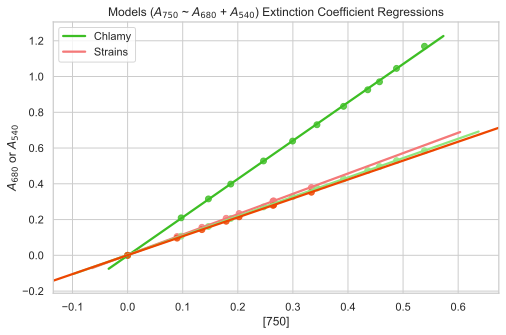

In [14]:
#for 
fig,ax = plt.subplots(figsize=(8,5))



C = get_row_col_values(mdf, plate_row_or_col='row', df_col_name=fst_regd)[-1]
c = get_row_col_values(mdf, plate_row_or_col='row', df_col_name=regr)[-1]
sns.regplot(y=C, x=c, color='#3dbe24')



B = get_row_col_values(mdf, plate_row_or_col='col', df_col_name=fst_regd)[-1]
b = get_row_col_values(mdf, plate_row_or_col='col', df_col_name=regr)[-1]
sns.regplot(y=B, x=b, color='#f47979')



C = get_row_col_values(mdf, plate_row_or_col='row', df_col_name=sec_regd)[-1]
c = get_row_col_values(mdf, plate_row_or_col='row', df_col_name=regr)[-1]
sns.regplot(y=C, x=c, color='#8fe67f')




B = get_row_col_values(mdf, plate_row_or_col='col', df_col_name=sec_regd)[-1]
b = get_row_col_values(mdf, plate_row_or_col='col', df_col_name=regr)[-1]
sns.regplot(y=B, x=b, color='#ed4600')



ax.set_title('Models ($A_{750}$ ~ $A_{680}$ + $A_{540}$) Extinction Coefficient Regressions')
ax.set_ylabel('$A_{680}$ or $A_{540}$')
ax.set_xlabel('[750]')
ax.legend(['Chlamy', 'Strains'])




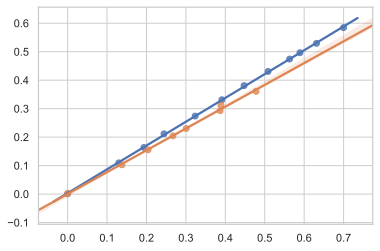

In [17]:
#kB_A720 

#for 

b = [i[1] for i in kB_A720]
kB = [i[0] for i in kB_A720]
C = get_row_col_values(mdf, plate_row_or_col='row', df_col_name='560')[-1]

'kB7'
kB[-1]
'kBb6'
(np.array(b[:-1]) / np.array(C[:-1])).mean()
sns.regplot(x=C, y=b)

#kC_A720 

b = [i[1] for i in kC_A720]
kC = [i[0] for i in kC_A720]

B = get_row_col_values(mdf, plate_row_or_col='col', df_col_name='560')[-1]

'kC7'
kC[-1]
'kCb6'
(np.array(b[:-1]) / np.array(B[:-1])).mean()
sns.regplot(x=B, y=b);

In [18]:
kB
kC

# Only the ABOVE is important

# Below is exploration...


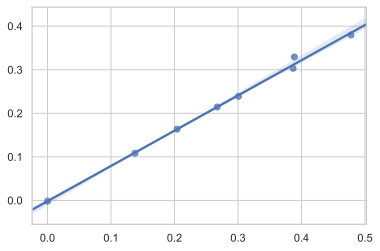

In [19]:
#kC_A680 

b = [i[1] for i in kC_A680]

B = get_row_col_values(mdf, plate_row_or_col='col', df_col_name='560')[-1]

b,C

sns.regplot(x=B, y=b);

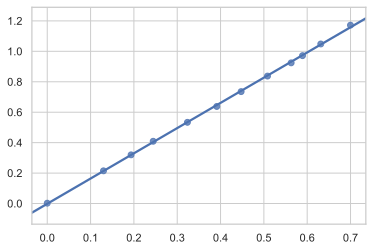

In [21]:
#kB_A720

b = [i[1] for i in kB_A680]

C = get_row_col_values(mdf, plate_row_or_col='row', df_col_name='560')[-1]

b
C

sns.regplot(x=C, y=b, );

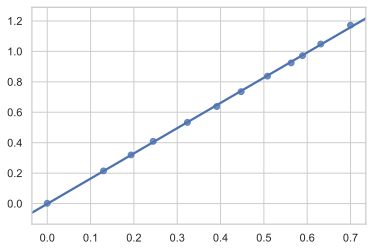

In [22]:
#kC_A720

b = [i[1] for i in kB_A680]

C = get_row_col_values(mdf, plate_row_or_col='row', df_col_name='560')[-1]

b
C

sns.regplot(x=C, y=b, );

In [23]:


(np.array(b)/np.array(C))[:-1].mean()

/home/rdmtinez/program_files/anaconda3/envs/fluxy/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


1.6523688801354084

In [24]:
kB_A680

[array([0.92002705, 1.17194254]),
 array([1.02537921, 1.04836632]),
 array([1.01319645, 0.97169014]),
 array([0.89779453, 0.92439858]),
 array([0.94292523, 0.8374393 ]),
 array([1.00074118, 0.73531395]),
 array([1.00414016, 0.63776503]),
 array([1.07072453, 0.53346763]),
 array([1.1363677, 0.4090055]),
 array([1.12483007, 0.31984837]),
 array([1.10925154, 0.21479552]),
 array([1.13869167, 0.00212891])]

In [25]:
kB_A680[0]
kC_A680
kB_A720
kC_A720

array([0.92002705, 1.17194254])

[array([1.95364272, 0.3797434 ]),
 array([2.07272273, 0.30324093]),
 array([2.00306395, 0.32928902]),
 array([2.11617711, 0.23902642]),
 array([2.0465526 , 0.21458914]),
 array([2.05282267, 0.16361584]),
 array([2.07248254, 0.10834698]),
 array([ 2.14229656e+00, -1.57312509e-03])]

[array([0.82935762, 0.58461104]),
 array([0.89190257, 0.52944263]),
 array([0.88415278, 0.4965277 ]),
 array([0.84395688, 0.47423117]),
 array([0.88869851, 0.43073078]),
 array([0.9350636 , 0.38084489]),
 array([0.95490678, 0.33140241]),
 array([1.01910238, 0.27401852]),
 array([1.05005705, 0.2116239 ]),
 array([1.04814191, 0.16365045]),
 array([1.04196163, 0.10967242]),
 array([1.05742538e+00, 7.96350475e-04])]

[array([0.90042346, 0.3607893 ]),
 array([0.98569495, 0.29293097]),
 array([0.92441292, 0.31197629]),
 array([1.0288514, 0.230315 ]),
 array([0.97887745, 0.20457003]),
 array([0.99464379, 0.15542164]),
 array([1.02412131, 0.10288874]),
 array([1.08286204, 0.00221282])]

In [26]:
[]

[]

In [28]:
for k in [kB_A680, kB_A750]:
    np.mean(k, axis=0)
    # note that the 

    
for k in [kC_A680, kC_A750]:
    np.mean(k, axis=0)

NameError: name 'kB_A750' is not defined

In [ ]:
kcs=[kB_A680, kB_A750, kC_A680, kC_A750]
for kc in kcs:
    np.mean(kc, axis=0)[0]

# Data Viz Setup 680 & 720

In [ ]:
# Currently I'm just regressor as 560, but if changed then everything in this
# this box should be run so that the values match accordingly
mdf = set_B_and_C(mdf, column='560')

#################################################

# store absorbance values that will be plotted on one figure  [chlamy]
A680_C = get_row_col_values(mdf, 'row', df_col_name='A680')
A720_C = get_row_col_values(mdf, 'row', df_col_name='A720')

# store absorbance values that will be plotted on one figure  [bacteria]
A680_B = get_row_col_values(mdf, 'col', df_col_name='A680')
A720_B = get_row_col_values(mdf, 'col', df_col_name='A720')

chlamy_cnt = mdf['C'].unique()
bacter_cnt = mdf['B'].unique()

kB_A680 = scipy_optfit_caller(bacter_cnt, A680_B)
kC_A680 = scipy_optfit_caller(chlamy_cnt, A680_C)
kB_A720 = scipy_optfit_caller(bacter_cnt, A720_B)
kC_A720 = scipy_optfit_caller(chlamy_cnt, A720_C)

In [ ]:
plot_col_rows(mdf, kParams=(kB_A680, kB_A720), second_regressand='A720', regressor='510', plate_row_or_col='col')
plot_col_rows(mdf, kParams=(kC_A680, kC_A720), second_regressand='A720', regressor='510', plate_row_or_col='row')

# change the plotting function to accept the wavelength that you want to use

In [ ]:
kB_A680
kC_A680
kB_A720
kC_A720

In [ ]:
def get_vals(tdf, column):
    """This helper function sets the concentraiton values B and
    C on the dataframe for regressiong purposes and so that the 
    plotting function can plot the right values on the x-axis"""
    
    df = tdf.copy()
    
    rows = df['row'].unique()
    cols =  df['col'].unique()
    
    
    r = []
    for row in rows:
        value = df.loc[(df['row']==row) & (df['col']==12), column][0]
        r.append(value)

    c = []
    for col in cols:
        
        value = df.loc[(df['row']=='H') & (df['col']==col), column][0]
        c.append(value)
    
    return r

In [ ]:
mdf.columns[12:-2]

In [ ]:
for col in mdf.columns[12:-2]:
    col, vals
    vals = get_vals(mdf,col)
    plt.plot(range(len(vals)), vals)